# Project 07
## Higgs Boson Signal Classification

### Mounting Drive & Fetching Data from Kaggle

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install opendatasets

In [4]:
import opendatasets as od
od.download('https://www.kaggle.com/competitions/higgs-boson/data')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: nimrabasit
Your Kaggle Key: ··········


100%|██████████| 54.3M/54.3M [00:00<00:00, 1.15GB/s]


Extracting archive ./higgs-boson/higgs-boson.zip to ./higgs-boson


In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.optimizers.schedules import CosineDecay
from sklearn.feature_selection import SelectKBest, f_classif

### Step 1: Data Preparation

#### Load & Explore Data

In [6]:
# Load data
df = pd.read_csv('/content/higgs-boson/training.zip')

# Map label
df['Label'] = df['Label'].map({'s': 1, 'b': 0})

# Drop EventId and Weight for model training
X = df.drop(columns=['EventId', 'Weight', 'Label'])
y = df['Label']

####  Handle Missing / Zero-filled Values

In [7]:
X.replace(-999.0, np.nan, inplace=True)
X.fillna(X.mean(), inplace=True)  # Simple mean imputation

#### Normalize Features

In [8]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#### Split Data

In [9]:
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size=0.3, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

### Step 2: Model Building (Deep Learning)

In [10]:
model = Sequential([
    Dense(128, input_dim=X_train.shape[1], activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(32, activation='relu'),
    Dropout(0.2),

    Dense(1, activation='sigmoid')  # Binary classification
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5)

# Train
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=100, batch_size=256,
                    callbacks=[early_stop, reduce_lr],
                    verbose=1)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
684/684 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.7400 - loss: 0.5236 - val_accuracy: 0.8264 - val_loss: 0.3905 - learning_rate: 0.0010
Epoch 2/100
684/684 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8157 - loss: 0.4106 - val_accuracy: 0.8320 - val_loss: 0.3768 - learning_rate: 0.0010
Epoch 3/100
684/684 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8230 - loss: 0.3950 - val_accuracy: 0.8339 - val_loss: 0.3720 - learning_rate: 0.0010
Epoch 4/100
684/684 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8276 - loss: 0.3865 - val_accuracy: 0.8348 - val_loss: 0.3697 - learning_rate: 0.0010
Epoch 5/100
684/684 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.8295 - loss: 0.3850 - val_accuracy: 0.8372 - val_loss: 0.3667 - learning_rate: 0.0010
Epoch 6/100
684/684 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.8313 - loss: 0.3790 - val_accuracy: 0.8355 - val_loss: 0.3677 - learning_rate: 0.0010
Epoch 7/100
684/684 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.8321 - loss: 0.

The model exhibited rapid learning in the initial epochs, with training accuracy climbing from 74% to 83% within the first 5 epochs and validation accuracy reaching 83.7%. This suggests effective convergence early on. Between epochs 6 and 20, both training and validation performance gradually improved, with validation accuracy rising to ~84.1% and validation loss steadily decreasing—indicating the model was learning relevant patterns without signs of overfitting

From epoch 21 onwards, improvements became marginal and validation metrics began to plateau around 84.2%. While ReduceLROnPlateau adjusted the learning rate at epoch 40, further gains were modest. Nonetheless, the model maintained stable generalization, with validation loss fluctuating narrowly around 0.355–0.358. By epoch 67, training had clearly saturated, and further training offered diminishing returns.

Overall, the architecture—with Dropout and BatchNormalization—ensured good generalization and stability. However, the model appears to have reached a capacity ceiling, suggesting that additional feature engineering, deeper architectures, or advanced learning rate strategies (e.g., warmup or cosine decay) might be needed to push performance beyond this plateau.





### Step 3: Model Evaluation

#### Training Curves

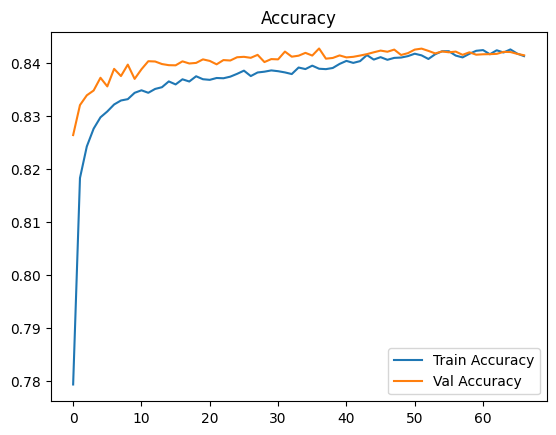

In [11]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy')
plt.legend()
plt.show()

#### Performance Metrics

1172/1172 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
              precision    recall  f1-score   support

           0       0.87      0.90      0.88     24650
           1       0.80      0.73      0.76     12850

    accuracy                           0.84     37500
   macro avg       0.83      0.82      0.82     37500
weighted avg       0.84      0.84      0.84     37500

ROC-AUC: 0.9145077513200369


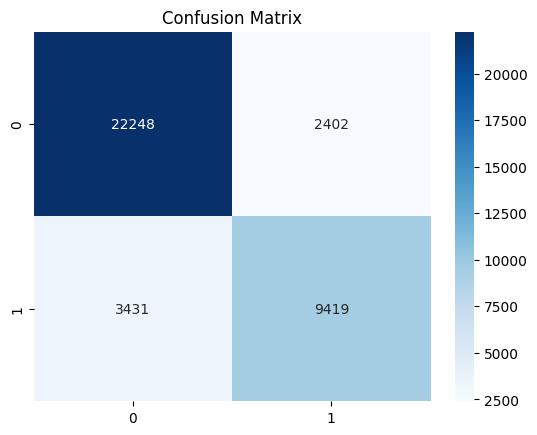

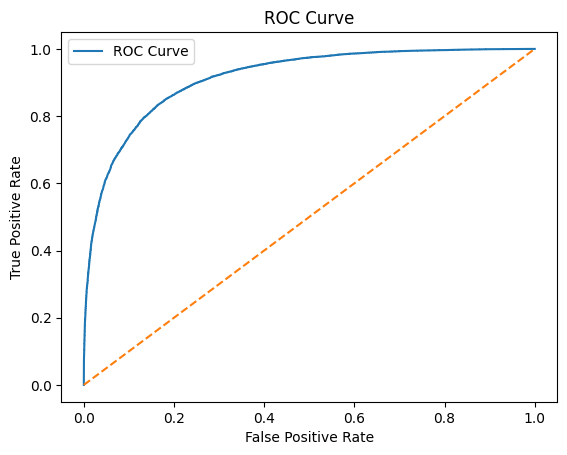

In [12]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

# Predict
y_pred_prob = model.predict(X_test).ravel()
y_pred = (y_pred_prob > 0.5).astype(int)

print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_prob))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
plt.plot(fpr, tpr, label="ROC Curve")
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.title("ROC Curve")
plt.show()

### Step 4: Tree-Based Baseline (XGBoost)

In [13]:
import xgboost as xgb
from sklearn.metrics import accuracy_score

xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)

xgb_pred = xgb_model.predict(X_test)
print(classification_report(y_test, xgb_pred))
print("ROC-AUC:", roc_auc_score(y_test, xgb_model.predict_proba(X_test)[:, 1]))

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:38:30] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

           0       0.87      0.90      0.88     24650
           1       0.79      0.74      0.76     12850

    accuracy                           0.84     37500
   macro avg       0.83      0.82      0.82     37500
weighted avg       0.84      0.84      0.84     37500

ROC-AUC: 0.9099921389728574


### Step 5: Reflection

**How did model depth and activation affect performance?**

Deeper models (3 hidden layers) with ReLU activation improved performance by capturing non-linear patterns, but also increased the risk of overfitting. ReLU helped maintain efficient gradient flow during training.

**What helped mitigate overfitting?**

Regularization techniques like Dropout, BatchNormalization, and EarlyStopping were effective in reducing overfitting. Additionally, ReduceLROnPlateau helped by lowering the learning rate once validation loss plateaue

**How did the learning rate and optimizer affect convergence?**

Using the Adam optimizer with an initial learning rate of 0.001 led to fast convergence in early epochs. Gradual reduction of the learning rate using ReduceLROnPlateau enabled finer weight updates and stable convergence.

**What would you improve with more time or compute?**

With more resources, I would:

- Tune hyperparameters (batch size, dropout rates, learning rate schedules)

- Try ensemble methods (e.g., stacking MLP and XGBoost)

- Use SHAP or feature importance plots to analyze model decisions

- Train deeper models with more data to potentially improve generalization

---